# Ideal Parameter Analysis ($\delta=2.25$, $\tau=1.25$, $\alpha=2.05$) ($\alpha$ slightly high)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau=1.25
expected_alpha=2.05

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

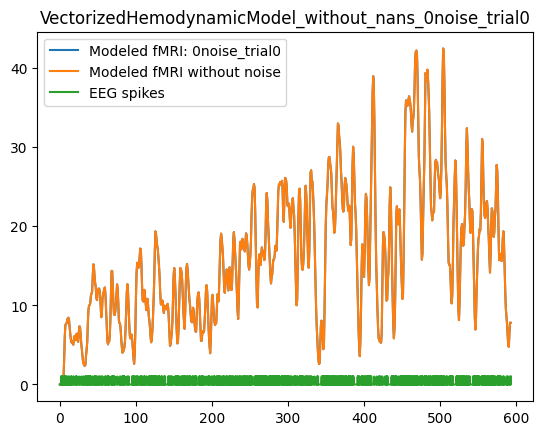

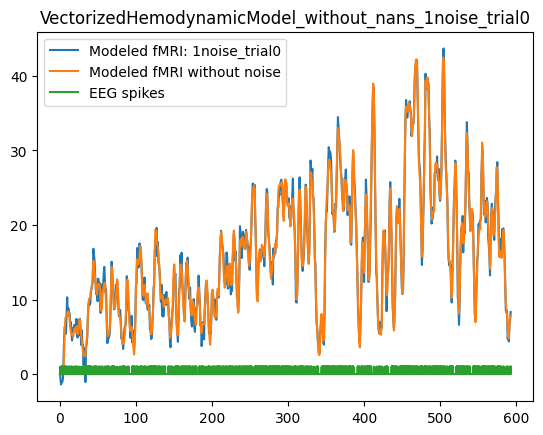

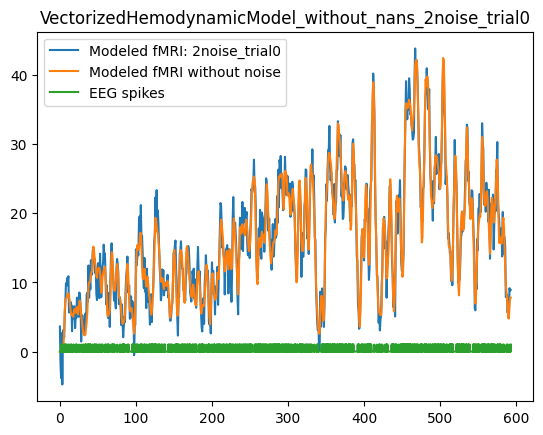

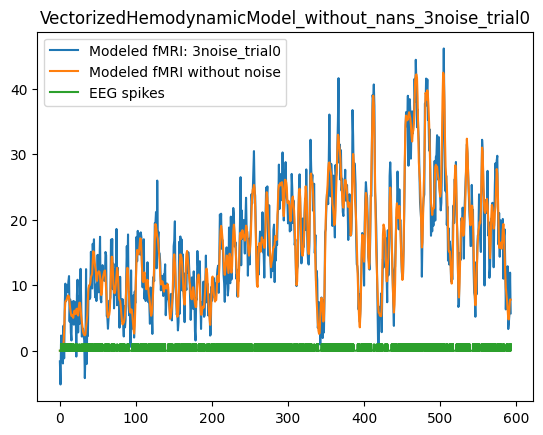

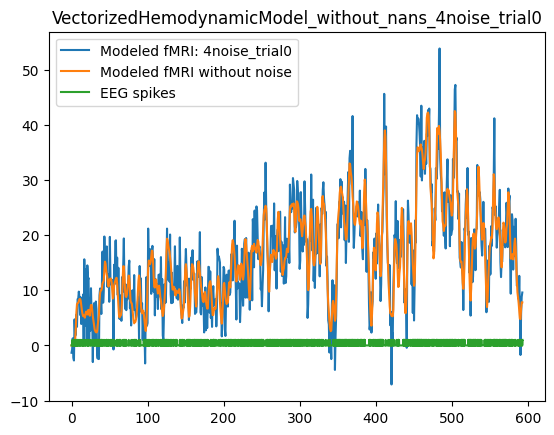

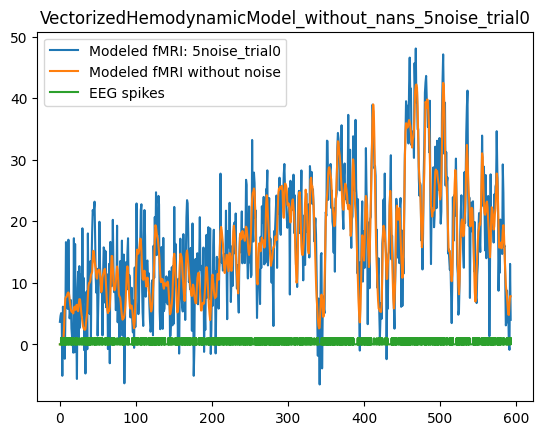

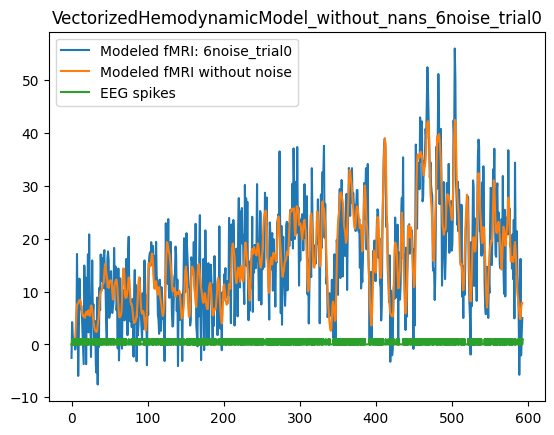

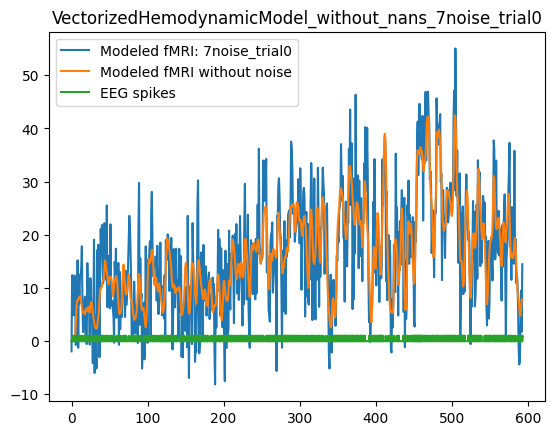

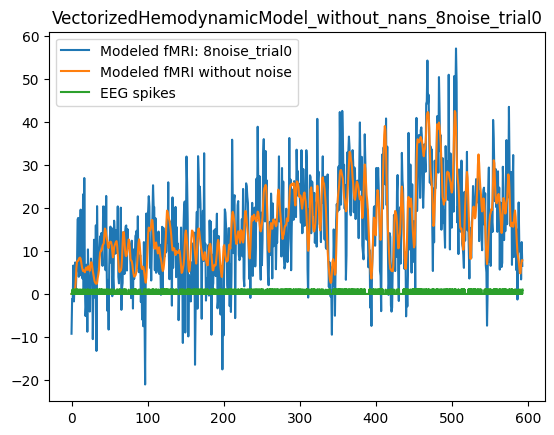

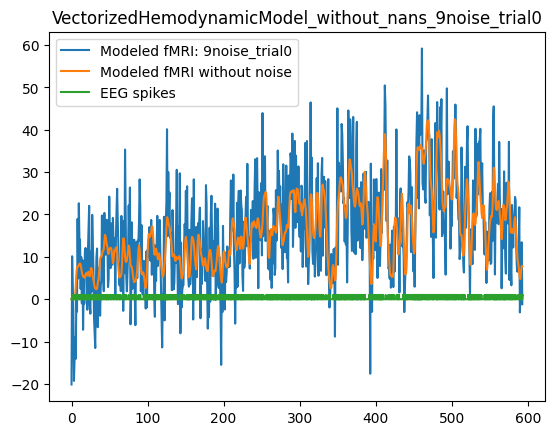

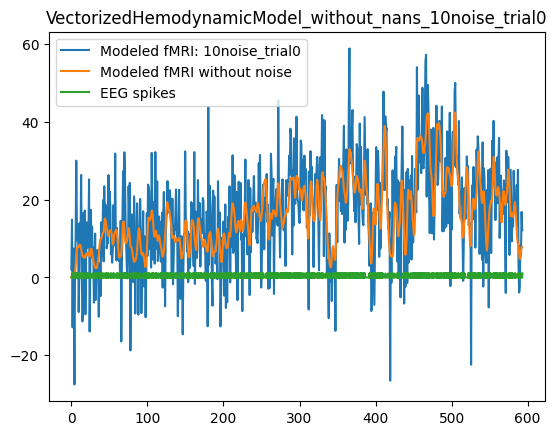

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2.05, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.25, tau=1.25, alpha=2.05


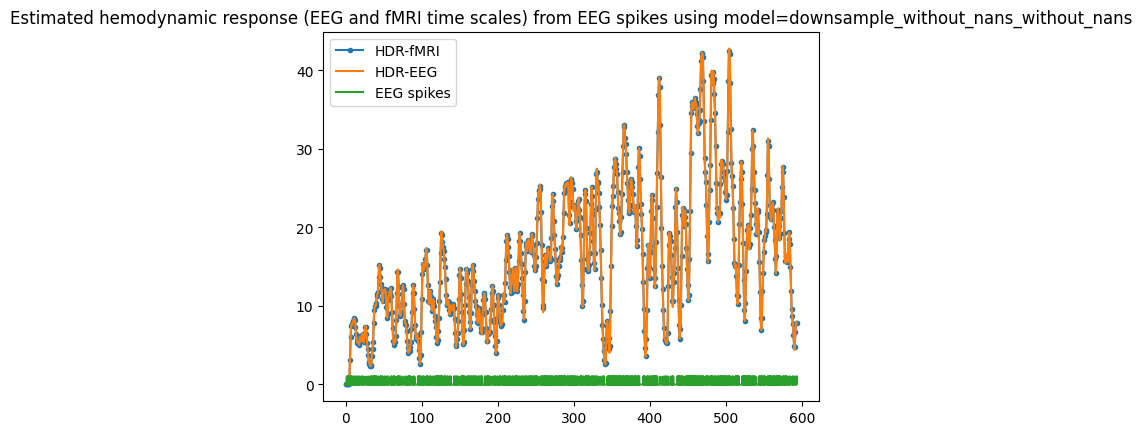

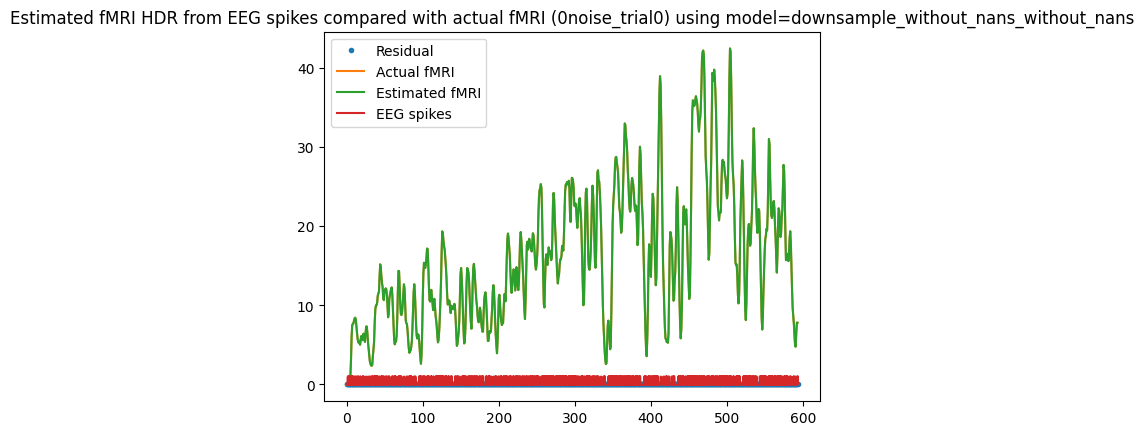

Residual Variance is 0.000000


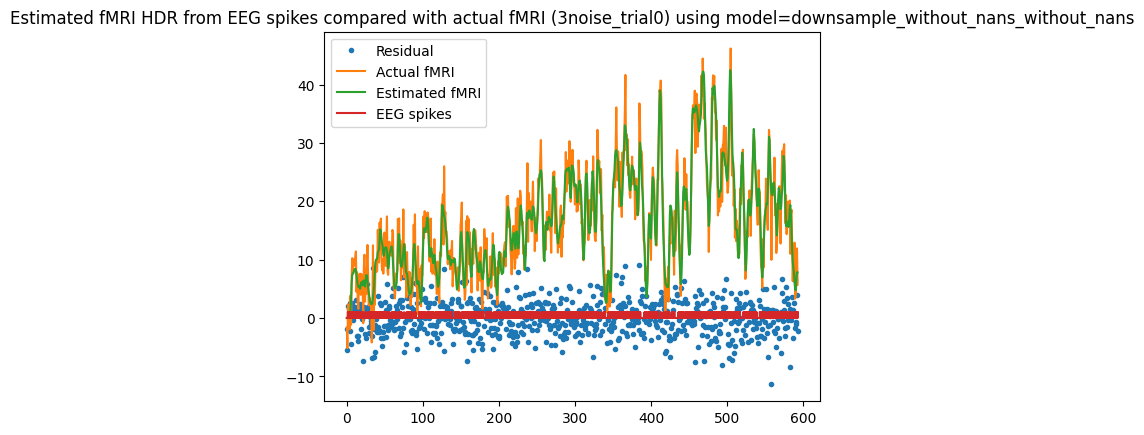

Residual Variance is 8.609445


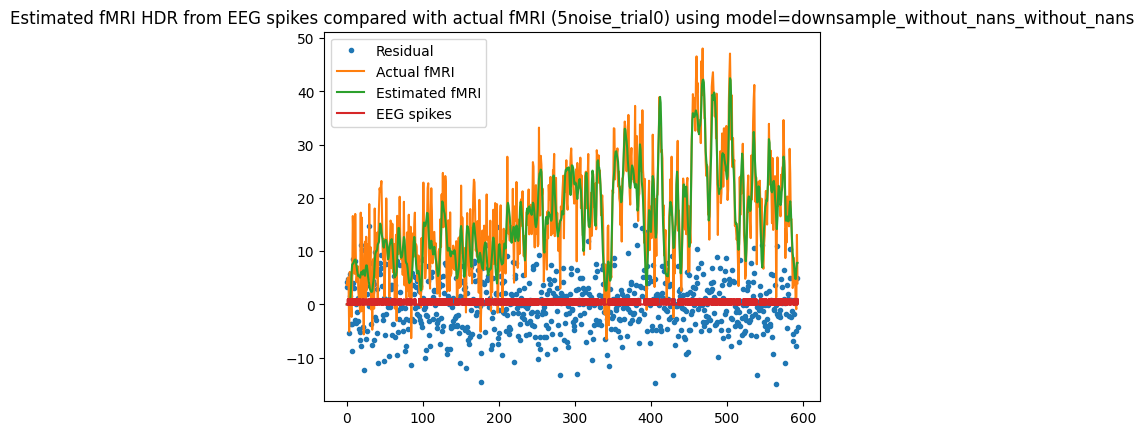

Residual Variance is 25.541501


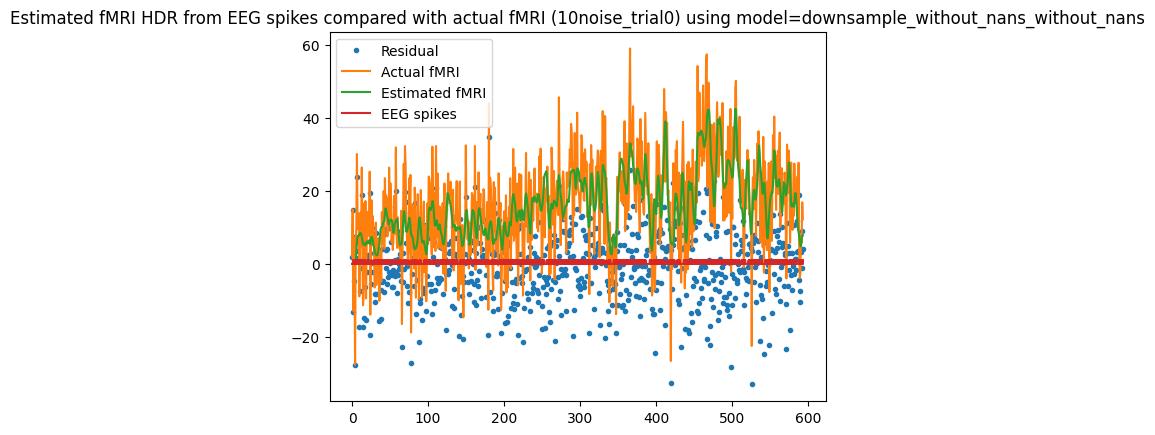

Residual Variance is 93.156331


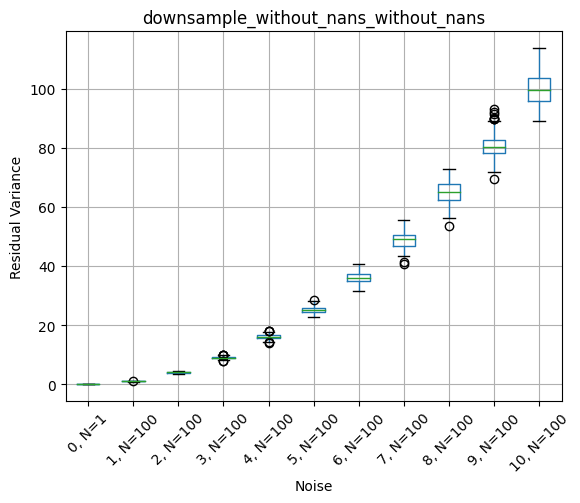

Scoring downsample_without_nans_with_nans delta=2.25, tau=1.25, alpha=2.05


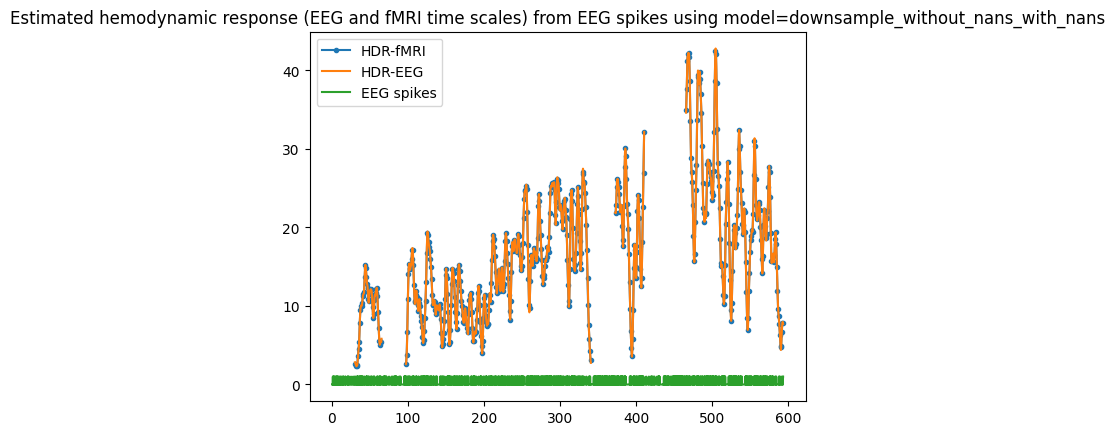

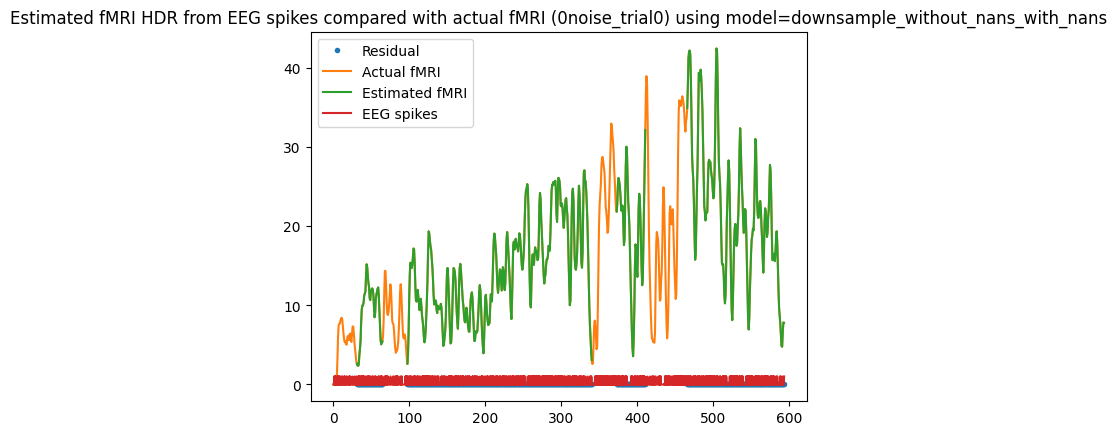

Residual Variance is 0.000000


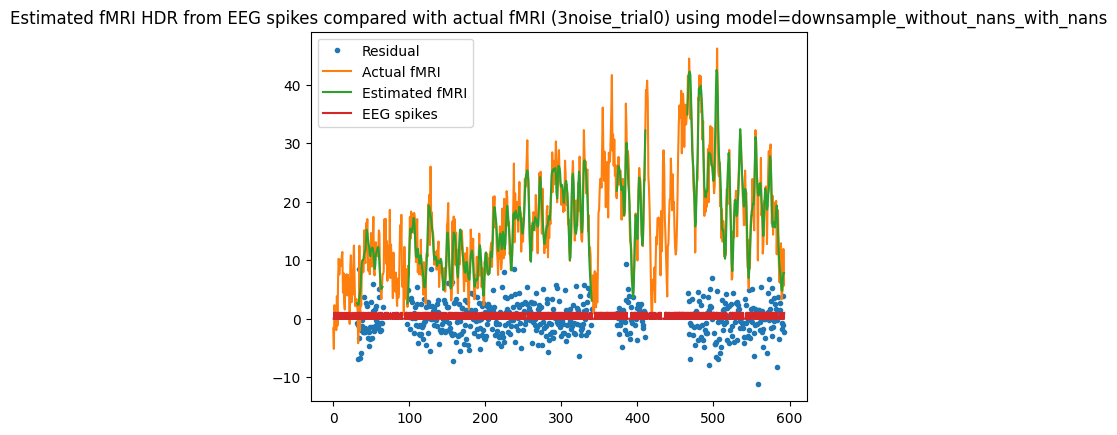

Residual Variance is 8.321447


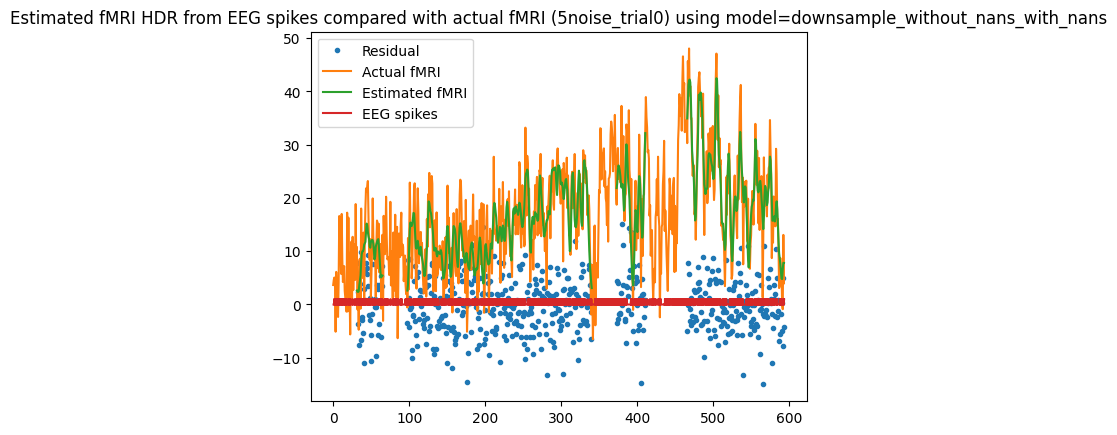

Residual Variance is 25.602378


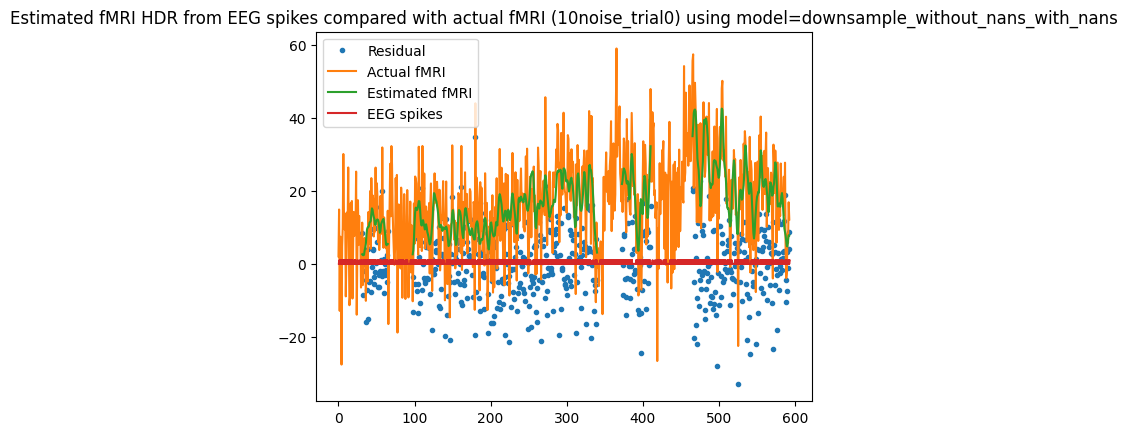

Residual Variance is 85.559548


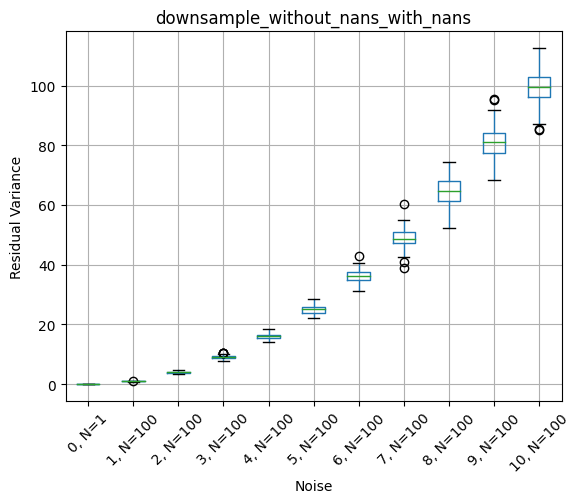

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans  44.414706244302664   
1         downsample_without_nans_with_nans   40.46230476767476   
2      downsample_without_nans_without_nans  43.564906832581634   
3         downsample_without_nans_with_nans  39.738736812231714   
4      downsample_without_nans_without_nans   42.70597674451746   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans  13.338145087521285   
18938  downsample_without_nans_without_nans  15.379953457434446   
18939     downsample_without_nans_with_nans  14.037938087140677   
18940  downsample_without_nans_without_nans  16.169100816353353   
18941     downsample_without_nans_with_nans   14.73252779895408   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0       45.85854393714109    46.8155178323972   52.58012936819093   
1      42.159825693829646   42.75314131172281  47.460415708709746   
2       45.00878543374638    45.9697710359001  51.742256571742836   
3      41.438511191718916    42.0285592968863   46.74408453826713   
4       44.15007345711189   45.11641614104507   50.89469357918645   
...                   ...                 ...                 ...   
18937  14.085963923068547  16.805515414960635  21.877457899981156   
18938   16.06354446510672  18.802540550429534  24.120863284585074   
18939  14.791517689523245  17.486744905233575   22.55525587831978   
18940   16.85217634083299   19.57642233723396   24.90432615682362   
18941  15.492640537276435   18.16374630456023   23.22653770778128   

            4noise_trial0      5noise_trial0  ...      1noise_trial99  \
0      60.561804153767305  72.42646033804286  ...  44.531867927911094   
1       54.20309912309787  67.54685596828072  ...    40.1312400741548   
2       59.74725582808221  71.57593197190498  ...   43.70010585796991   
3       53.54880329108767  66.81326258522411  ...   39.43266802251389   
4       58.92346149213113  70.71534351035203  ...  42.859423992610736   
...                   ...                ...  ...                 ...   
18937   25.83703263840912  38.24921053588679  ...   13.54670809242531   
18938   29.91660419061795  39.90918215081275  ...  15.668018968664072   
18939  26.471783069831723  38.94041929430278  ...  14.220406557736682   
18940  30.681424721454004  40.69938907522527  ...   16.43305077785063   
18941    27.1042303977431   39.6266467282442  ...   14.88958260643551   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0      48.580540834170414  55.043840202984214   60.38768175624115   
1       44.13332022696822  51.982062571777696   57.77960816351542   
2       47.73890825821622  54.217464603671296   59.54803421846393   
3      43.431110965341304  51.265179775997986   57.07505664028145   
4      46.887685574751025  53.381518590919804   58.70023461193505   
...                   ...                 ...                 ...   
18937   16.80785268691737   22.35033444980511   27.86451970039529   
18938  19.611151922238683  24.000273701359582  30.874341890963002   
18939   17.50154595429491  23.068437490382514  28.604163797

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 7.678778464247522e-29; at
       delta   tau  alpha
11782   2.25  1.25   2.05


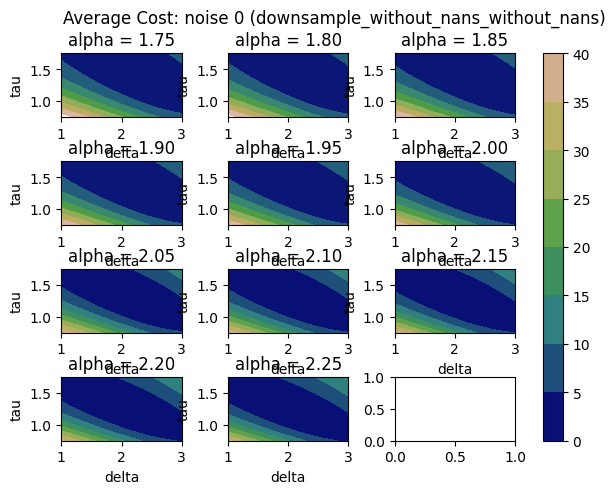

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              44.414706             
2                                              43.564907             
4                                              42.705977             
6                                              41.838582             
8                                              40.963412             
...                                                  ...             
18932                                          13.002099             
18934                                          13.795000             
18936                                          14.588122             
18938                                          15.379953             
18940                                          16.169101             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 2.05


delta   tau  alpha
0   2.25  1.25   2.05

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 2.05


noise iteration          cost  delta   tau  alpha
0      0         0  3.074969e-03   2.15  1.20   2.25
1      0         0  7.678778e-29   2.25  1.25   2.05
2      0         0  4.868938e-03   2.30  1.30   1.90
3      0         0  8.239703e-03   2.40  1.35   1.75

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         4.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration     cost  delta   tau  alpha
3      0         0  0.00824    2.4  1.35   1.75

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration      cost  delta  tau  alpha
0      0         0  0.003075   2.15  1.2   2.25

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 2.399834700655263e-28; at
       delta   tau  alpha
11783   2.25  1.25   2.05


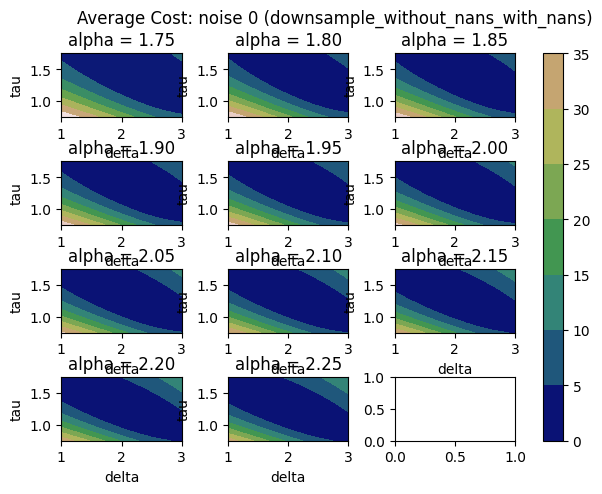

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              40.462305          
3                                              39.738737          
5                                              39.004482          
7                                              38.260071          
9                                              37.506071          
...                                                  ...          
18933                                          11.928130          
18935                                          12.634414          
18937                                          13.338145          
18939                                          14.037938          
18941                                          14.732528          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 2.05


delta   tau  alpha
0   2.25  1.25   2.05

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 2.05


noise iteration          cost  delta   tau  alpha
0      0         0  3.153901e-03   2.15  1.20   2.25
1      0         0  2.399835e-28   2.25  1.25   2.05
2      0         0  4.871215e-03   2.30  1.30   1.90
3      0         0  8.139372e-03   2.40  1.35   1.75

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         4.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration      cost  delta   tau  alpha
3      0         0  0.008139    2.4  1.35   1.75

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration      cost  delta  tau  alpha
0      0         0  0.003154   2.15  1.2   2.25

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 1.0076724250416438; at
       delta   tau  alpha
11782   2.25  1.25   2.05


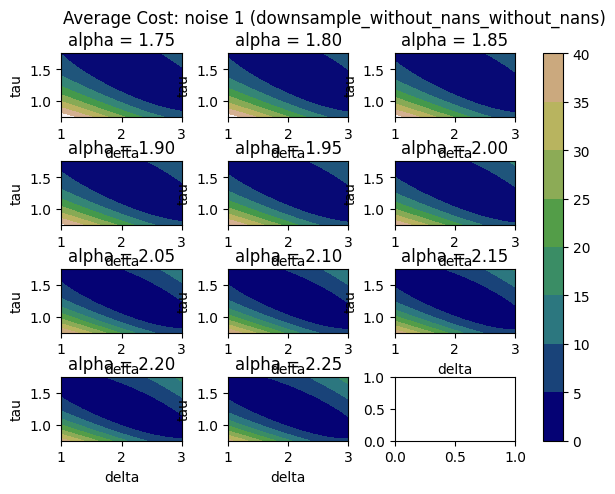

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 4.0283569203457805; at
       delta   tau  alpha
11782   2.25  1.25   2.05


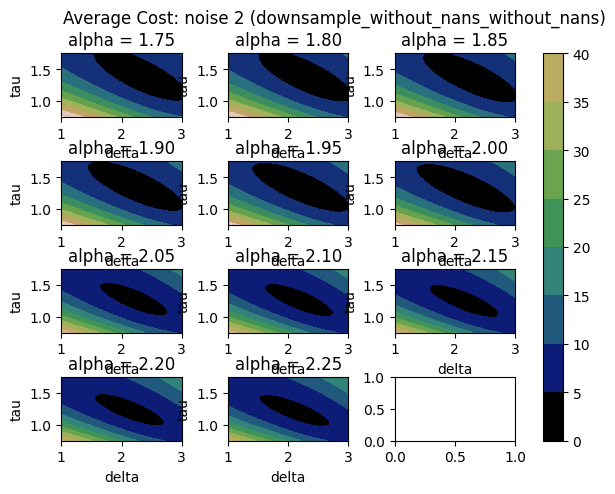

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 8.958941991734475; at
       delta   tau  alpha
11782   2.25  1.25   2.05


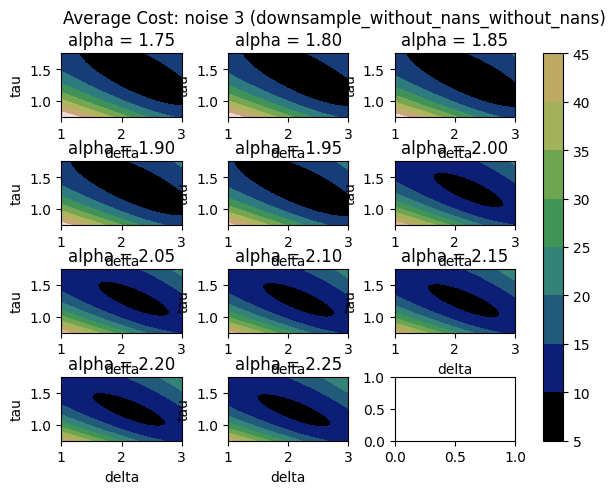

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 16.069727515198956; at
       delta   tau  alpha
11782   2.25  1.25   2.05


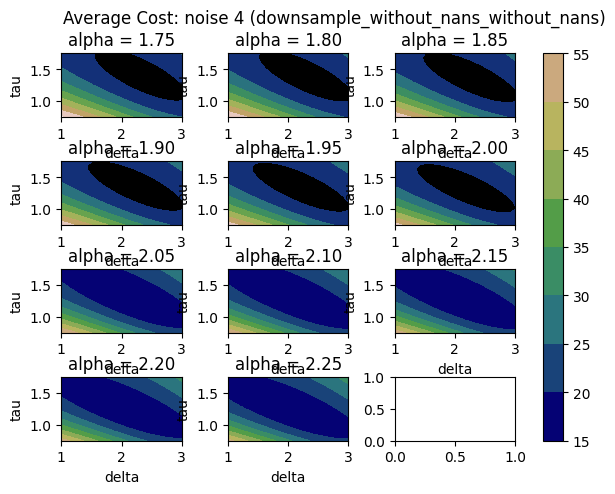

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 25.08929889362168; at
       delta   tau  alpha
11782   2.25  1.25   2.05


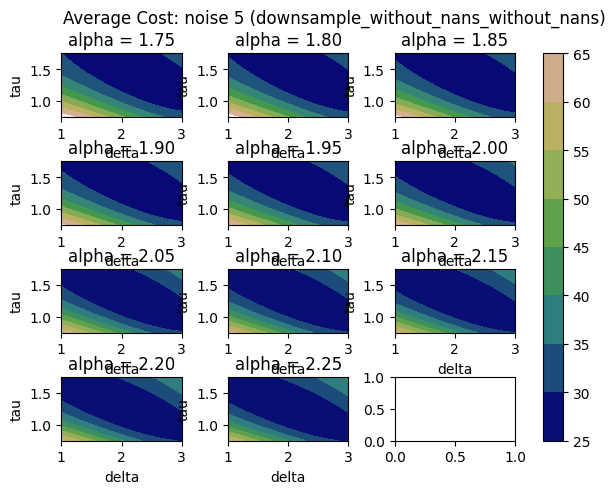

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.14488443381357; at
       delta   tau  alpha
11782   2.25  1.25   2.05


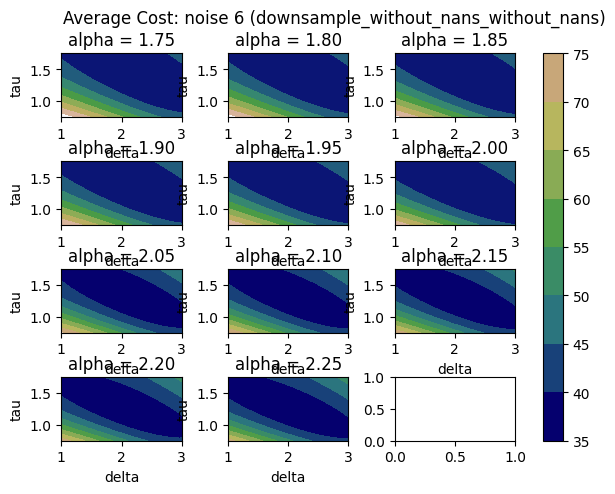

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 48.787948623164375; at
       delta   tau  alpha
11782   2.25  1.25   2.05


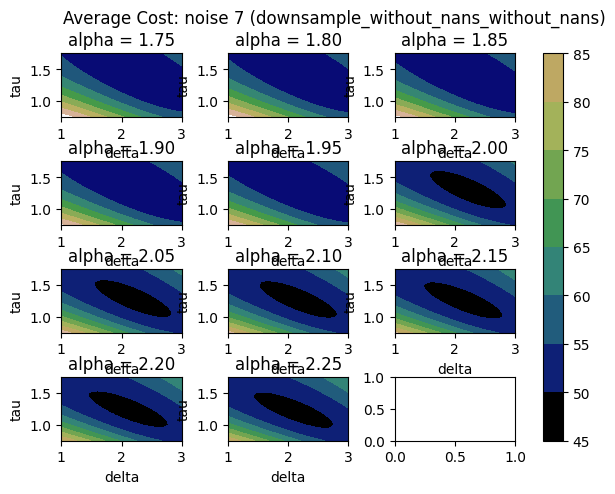

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 64.79672605324063; at
       delta  tau  alpha
10844   2.15  1.2   2.25


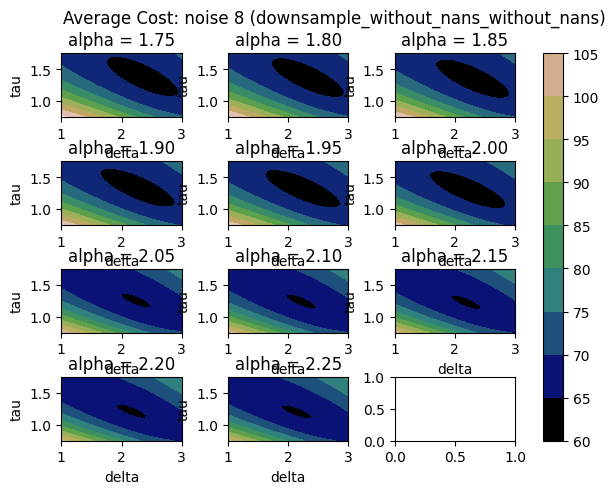

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 80.7081756278583; at
       delta   tau  alpha
11322    2.2  1.25    2.1


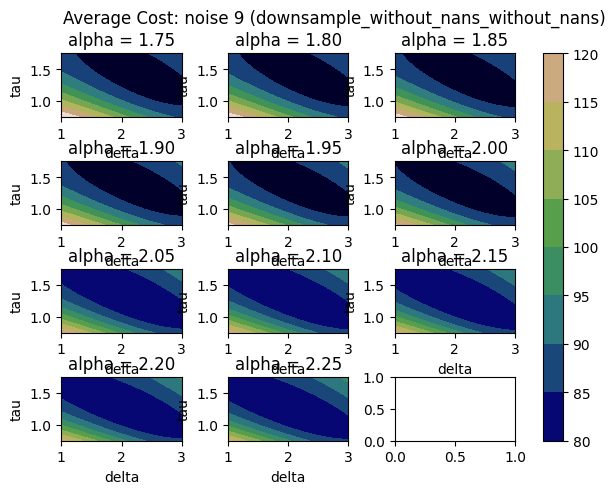

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 99.7855148590843; at
       delta  tau  alpha
11304    2.2  1.2    2.2


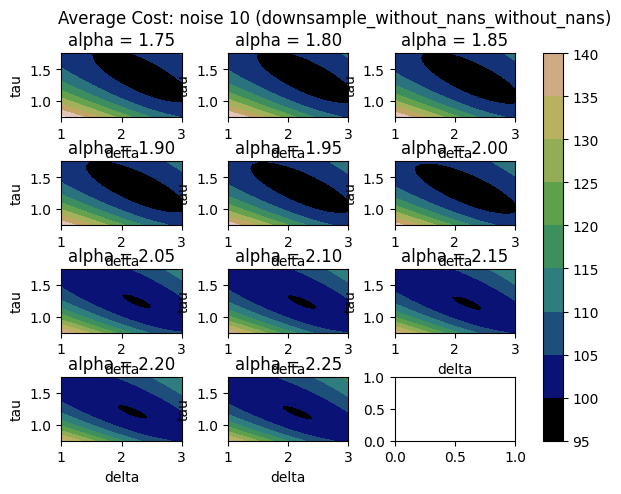

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

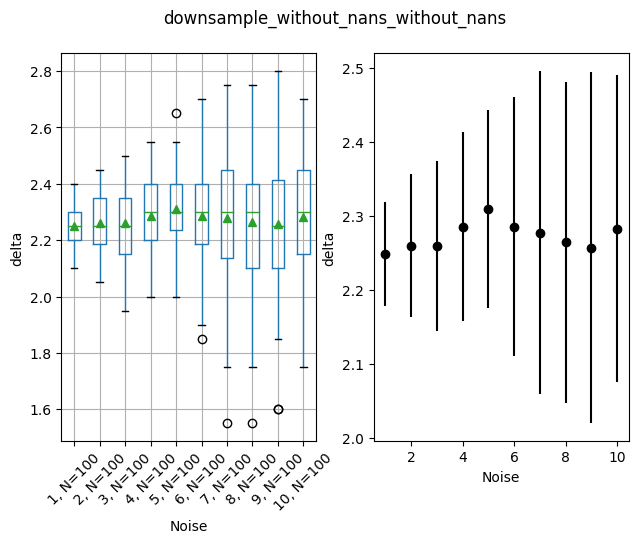

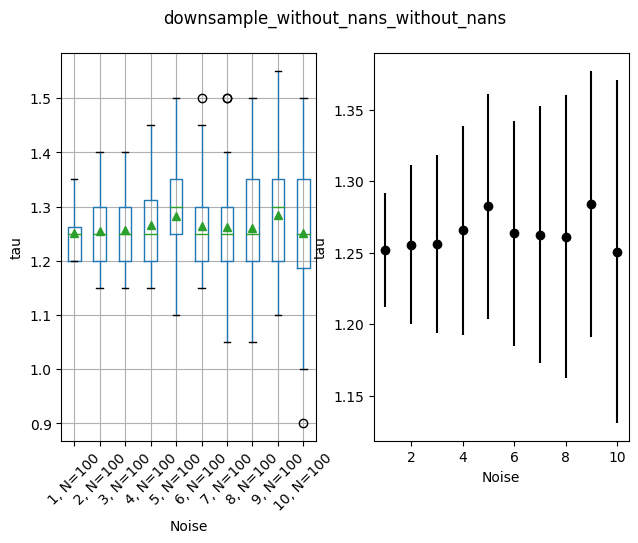

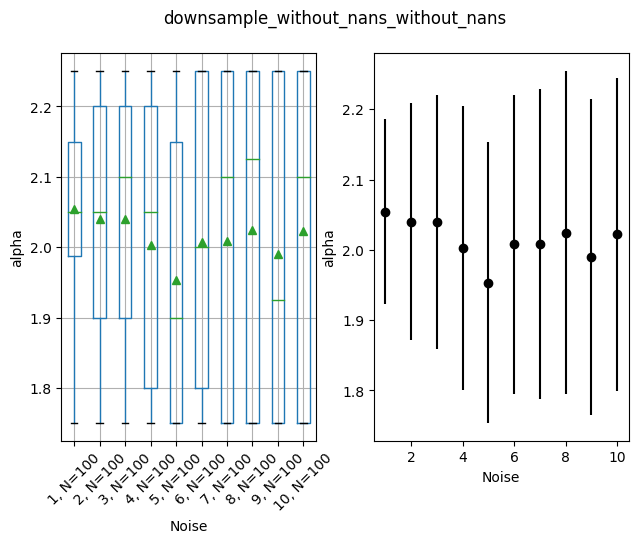

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 1.0105463536274273; at
       delta   tau  alpha
11783   2.25  1.25   2.05


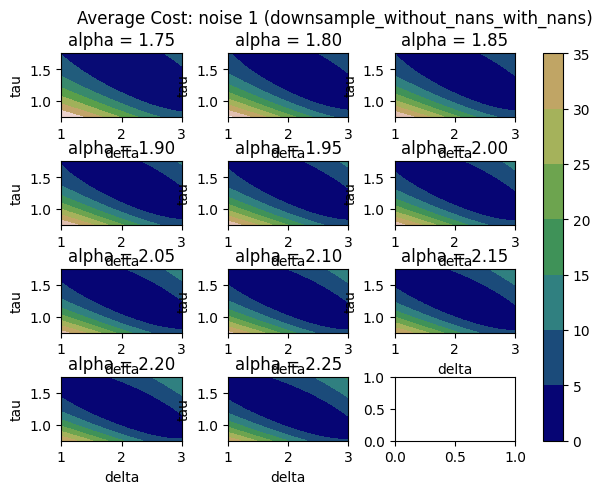

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.060020304219639; at
       delta   tau  alpha
11783   2.25  1.25   2.05


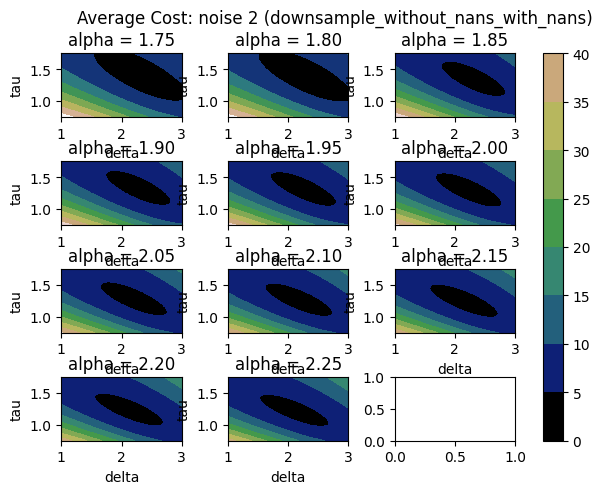

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 9.015993443711151; at
       delta   tau  alpha
11783   2.25  1.25   2.05


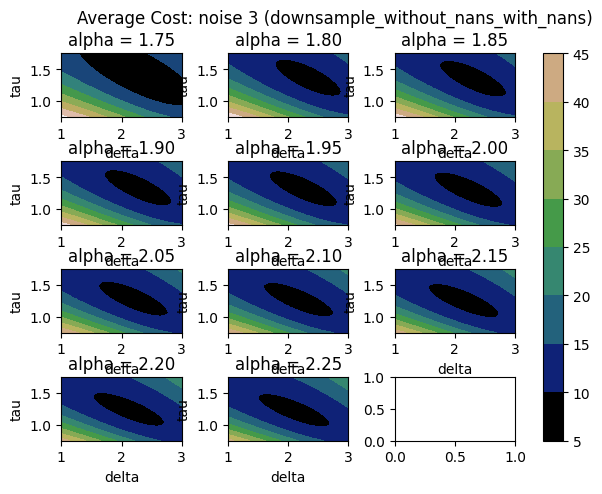

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 16.045854646787195; at
       delta   tau  alpha
11783   2.25  1.25   2.05


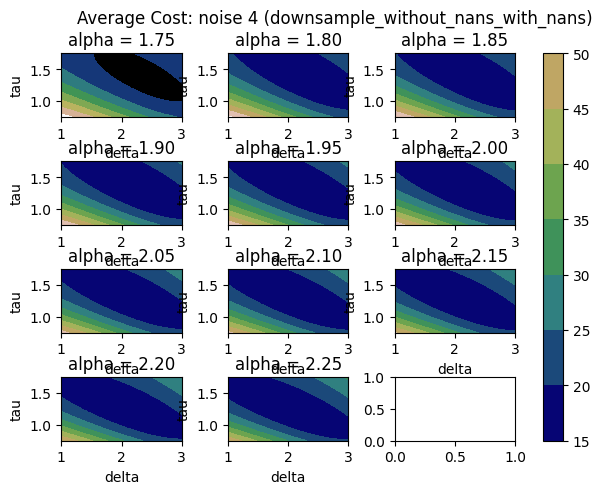

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 25.014411433573574; at
       delta   tau  alpha
11783   2.25  1.25   2.05


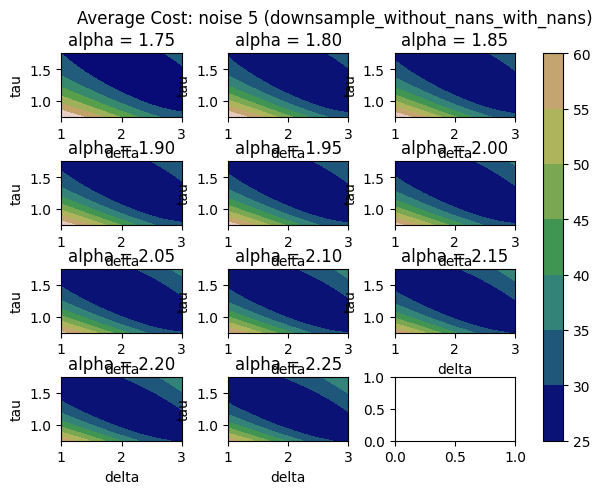

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 36.17753548398814; at
       delta   tau  alpha
11783   2.25  1.25   2.05


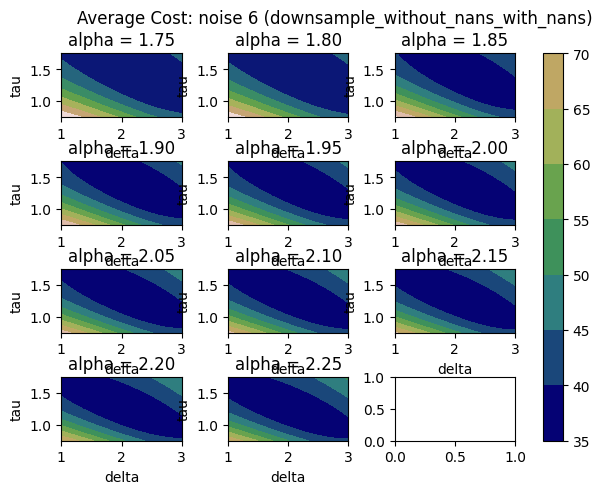

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.958907734595904; at
       delta   tau  alpha
11783   2.25  1.25   2.05


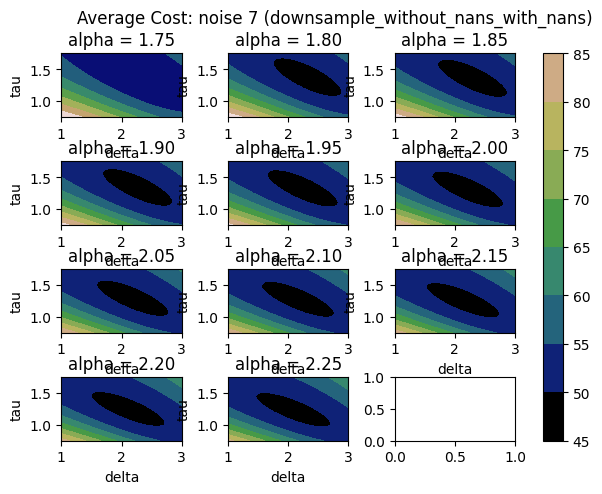

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 64.4848855883943; at
       delta   tau  alpha
11783   2.25  1.25   2.05


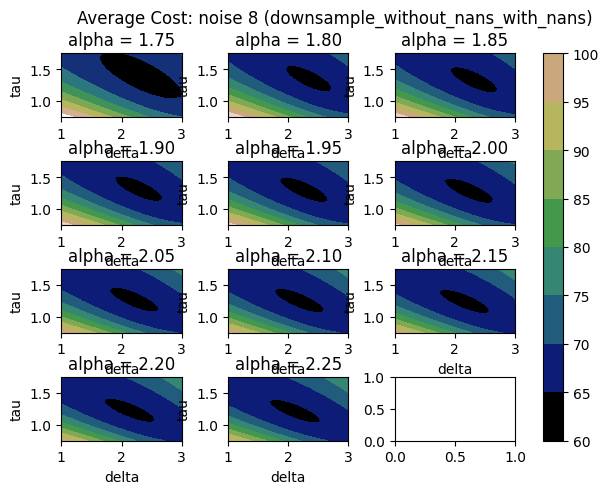

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 81.06537368020852; at
       delta   tau  alpha
11323    2.2  1.25    2.1


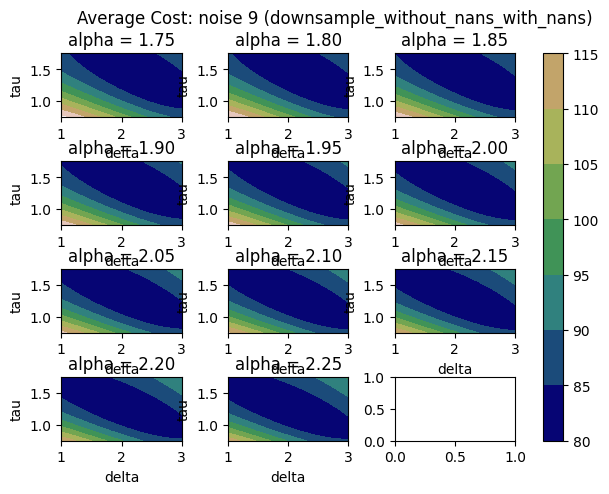

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 99.47951827342358; at
       delta   tau  alpha
12243    2.3  1.25    2.0


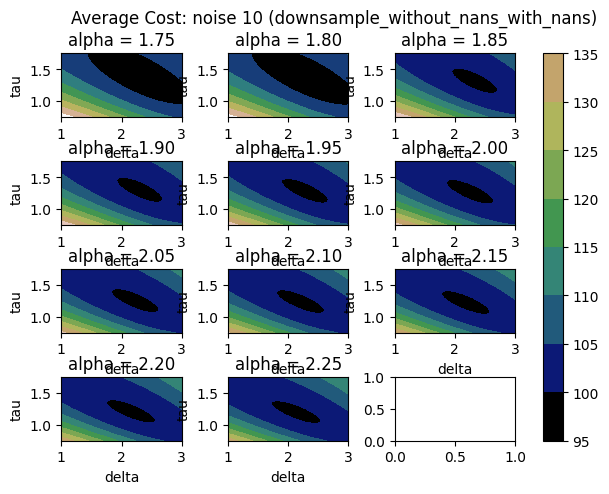

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


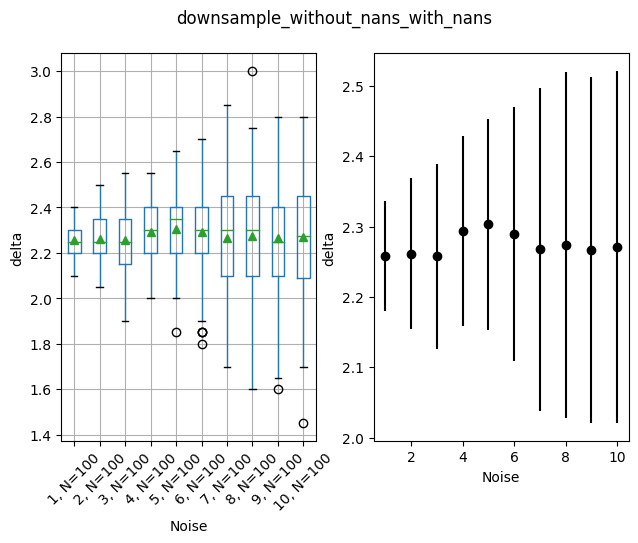

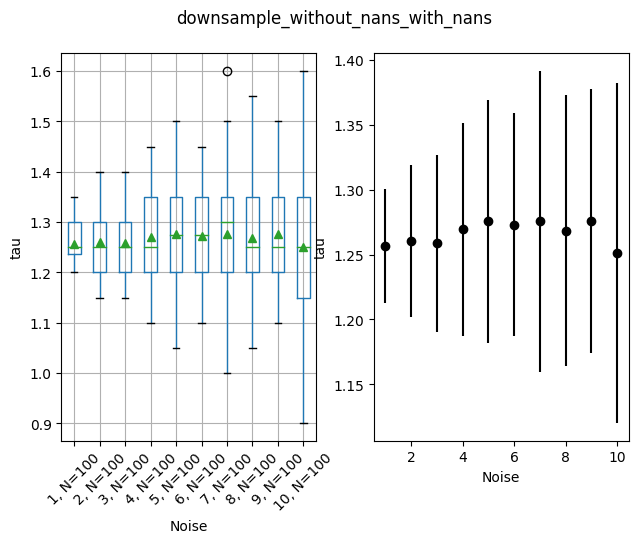

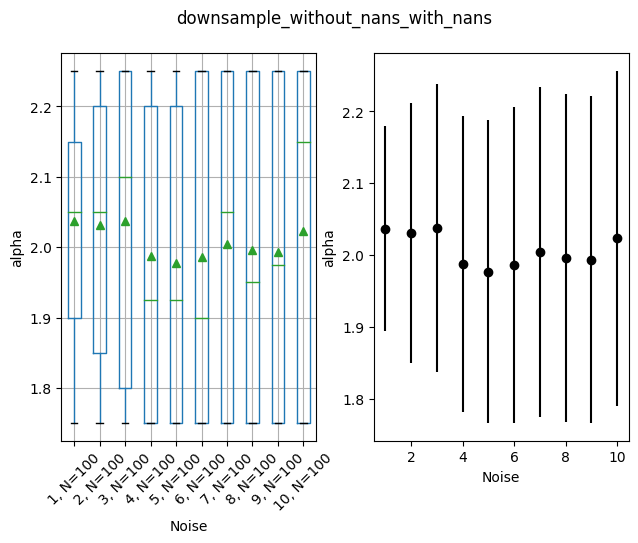

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        61    0.986757   2.100000000000001  1.2000000000000004   
1         1        66    1.026388   2.100000000000001  1.2000000000000004   
2         1        14    0.983151  2.1500000000000012  1.2000000000000004   
3         1        15    1.017066  2.1500000000000012  1.2000000000000004   
4         1        20    1.019960  2.1500000000000012  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2730     10         8   94.698111  2.6500000000000012  1.3000000000000005   
2731     10        84   98.628267  2.7000000000000015  1.1500000000000004   
2732     10        77  107.595172  2.7000000000000015  1.2000000000000004   
2733     10        95   95.281847  2.7000000000000015  1.3000000000000005   
2734     10        29  105.968024  2.7500000000000018  1.1500000000000004   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2                    2.2  
3                    2.2  
4                    2.2  
...                  ...  
2730                1.75  
2731                1.75  
2732                1.75  
2733                1.75  
2734  1.9000000000000001  

[2735 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                          
                       count  mean       std  min   25%  50%  75%  max
noise                                                                 
1                      100.0  3.74  0.463191  2.0  3.75  4.0  4.0  4.0
2                      100.0  3.48  0.611010  1.0  3.00  4.0  4.0  4.0
3                      100.0  3.15  0.821123  1.0  3.00  3.0  4.0  4.0
4                      100.0  2.90  0.948151  1.0  2.00  3.0  4.0  4.0
5                      100.0  2.84  1.079843  1.0  2.00  3.0  4.0  5.0
6                      100.0  2.44  1.094707  1.0  1.00  3.0  3.0  4.0
7                      100.0  2.37  1.142874  1.0  1.00  3.0  3.0  5.0
8                      100.0  2.20  1.271283  1.0  1.00  2.0  3.0  6.0
9                      100.0  2.16  1.079843  1.0  1.00  2.0  3.0  4.0
10                     100.0  2.07  1.148165  1.0  1.00  2.0  3.0  4.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
294       1        15    1.025697  2.3500000000000014  1.3500000000000005   
295       1        66    1.037321  2.3500000000000014  1.3500000000000005   
321       1         2    0.942884  2.4000000000000012  1.3500000000000005   
322       1         3    1.018537  2.4000000000000012  1.3500000000000005   
323       1         6    1.017270  2.4000000000000012  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2729     10        98  105.682335  2.6500000000000012  1.2000000000000004   
2730     10         8   94.698111  2.6500000000000012  1.3000000000000005   
2731     10        84   98.628267  2.7000000000000015  1.1500000000000004   
2732     10        77  107.595172  2.7000000000000015  1.2000000000000004   
2733     10        95   95.281847  2.7000000000000015  1.3000000000000005   

     alpha  
294   1.75  
295   1.75  
321   1.75  
322   1.75  
323   1.75  
...    ...  
2729  1.75  
2730  1.75  
2731  1.75  
2732  1.75  
2733  1.75  

[391 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        53      3  2.4000000000000012   49    53      1  1.3500000000000005   
10       34     11   2.450000000000001    5    34      8  1.3500000000000005   
2        36      5  2.4000000000000012   19    36      3  1.3500000000000005   
3        35      5  2.4000000000000012   12    35      3  1.3500000000000005   
4        41      7  2.4000000000000012   14    41      5  1.3500000000000005   
5        38     10  2.3500000000000014    8    38      4  1.3500000000000005   
6        29     11  2.4000000000000012    5    29      7  1.3000000000000005   
7        41     14  2.5500000000000016    9    41      8  1.3500000000000005   
8        42     11  2.3500000000000014    9    42      8  1.3500000000000005   
9        42     16   2.300000000000001    6    42      8  1.4000000000000006   

            
      freq  
noise       
1       53  
10       7  
2       32  
3       27  
4       22  
5       16  
6       11  
7       13  
8       10  
9       11

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        61    0.986757   2.100000000000001  1.2000000000000004   
1         1        66    1.026388   2.100000000000001  1.2000000000000004   
9         1         0    1.048658  2.1500000000000012  1.2000000000000004   
10        1         2    0.929643  2.1500000000000012  1.2000000000000004   
11        1         3    1.008690  2.1500000000000012  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2685     10        95   95.220205   2.450000000000001  1.1500000000000004   
2698     10        58   99.279372  2.5000000000000013  1.0500000000000003   
2716     10        90   95.855888  2.6000000000000014  0.9000000000000001   
2717     10        29  105.937243  2.6000000000000014  1.0500000000000003   
2725     10        86   97.311147  2.6500000000000012  1.0000000000000002   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
9     2.2500000000000004  
10    2.2500000000000004  
11    2.2500000000000004  
...                  ...  
2685  2.2500000000000004  
2698  2.2500000000000004  
2716  2.2500000000000004  
2717  2.2500000000000004  
2725  2.2500000000000004  

[447 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        53      3  2.1500000000000012   49    53      1  1.2000000000000004   
10       53     17   2.250000000000001    7    53      9  1.2500000000000004   
2        39      5  2.1500000000000012   20    39      2  1.2000000000000004   
3        43      7  2.1500000000000012   14    43      3  1.2000000000000004   
4        38      9  2.1500000000000012   13    38      3  1.2000000000000004   
5        40      9   2.200000000000001   10    40      5  1.2000000000000004   
6        43     13   2.250000000000001    7    43      6  1.1500000000000004   
7        36     12   2.100000000000001    8    36      8  1.2000000000000004   
8        52     15   2.200000000000001    7    52      8  1.2000000000000004   
9        50     16  1.9500000000000008    7    50      8  1.2000000000000004   

            
      freq  
noise       
1       53  
10      10  
2       32  
3       26  
4       20  
5       17  
6       15  
7       11  
8       17  
9       14

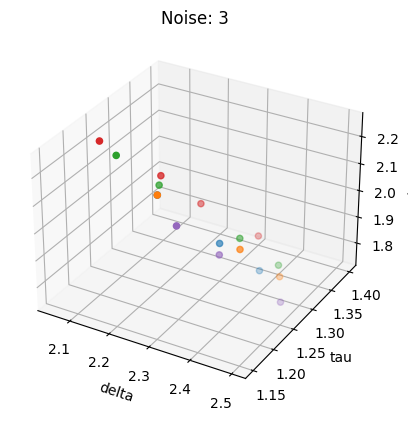

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

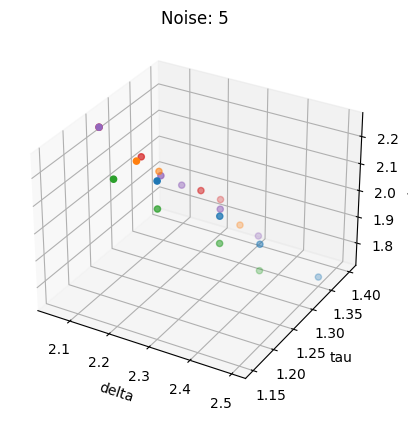

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

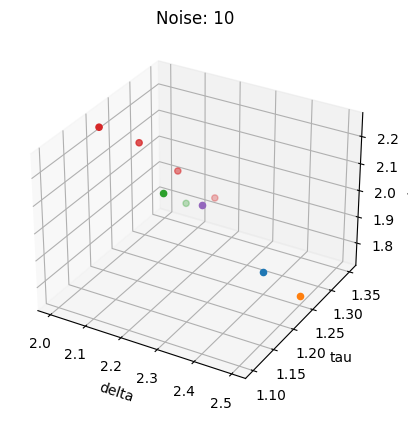

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        43    1.127702   2.100000000000001  1.2000000000000004   
1         1        60    1.049621   2.100000000000001  1.2000000000000004   
2         1        61    0.976128   2.100000000000001  1.2000000000000004   
3         1        62    1.029060   2.100000000000001  1.2000000000000004   
4         1        14    0.961356  2.1500000000000012  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2534     10        46   99.597626  2.7000000000000015  1.3500000000000005   
2535     10        90   93.632691  2.7500000000000018  0.9500000000000002   
2536     10        86   98.069703  2.7500000000000018  1.1000000000000003   
2537     10        98  106.579264  2.8000000000000016  1.1000000000000003   
2538     10        90   93.646618  2.8500000000000014  1.0000000000000002   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4                    2.2  
...                  ...  
2534                1.75  
2535                 2.0  
2536                1.85  
2537                1.75  
2538                1.75  

[2539 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.64  0.522620  2.0  3.0  4.0  4.0  4.0
2                      100.0  3.22  0.718866  1.0  3.0  3.0  4.0  4.0
3                      100.0  2.97  0.858175  1.0  3.0  3.0  4.0  4.0
4                      100.0  2.71  1.130790  1.0  2.0  3.0  4.0  4.0
5                      100.0  2.55  1.166667  1.0  1.0  3.0  4.0  4.0
6                      100.0  2.28  1.155400  1.0  1.0  2.0  3.0  4.0
7                      100.0  2.03  1.123262  1.0  1.0  2.0  3.0  4.0
8                      100.0  2.14  1.172238  1.0  1.0  2.0  3.0  5.0
9                      100.0  1.97  1.149923  1.0  1.0  1.0  3.0  4.0
10                     100.0  1.88  1.085069  1.0  1.0  1.0  3.0  4.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration       cost               delta                 tau alpha
2153      8        25  62.451469  3.0000000000000018  1.0500000000000003  1.75

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
289       1        15    0.992858  2.3500000000000014  1.3500000000000005   
290       1        30    1.074319  2.3500000000000014  1.3500000000000005   
291       1        60    1.044536  2.3500000000000014  1.3500000000000005   
292       1        62    1.040854  2.3500000000000014  1.3500000000000005   
293       1        66    1.004544  2.3500000000000014  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2529     10        30  104.577709  2.6000000000000014  1.3500000000000005   
2532     10        25   97.889529  2.7000000000000015  1.1500000000000004   
2534     10        46   99.597626  2.7000000000000015  1.3500000000000005   
2537     10        98  106.579264  2.8000000000000016  1.1000000000000003   
2538     10        90   93.646618  2.8500000000000014  1.0000000000000002   

     alpha  
289   1.75  
290   1.75  
291   1.75  
292   1.75  
293   1.75  
...    ...  
2529  1.75  
2532  1.75  
2534  1.75  
2537  1.75  
2538  1.75  

[406 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        46      3  2.4000000000000012   37    46      1  1.3500000000000005   
10       40     16  2.5500000000000016    7    40     12  1.3500000000000005   
2        34      5  2.4000000000000012   17    34      3  1.3500000000000005   
3        29      8  2.4000000000000012    8    29      3  1.3500000000000005   
4        46      7  2.3500000000000014   14    46      5  1.3500000000000005   
5        45     11  2.3500000000000014   10    45      6  1.3500000000000005   
6        37     12  2.4000000000000012    9    37      7  1.3500000000000005   
7        42     15  2.5000000000000013    8    42      8  1.3000000000000005   
8        44     15  2.4000000000000012   10    44     10  1.4000000000000006   
9        43     15  2.4000000000000012   10    43      9  1.3500000000000005   

            
      freq  
noise       
1       46  
10       8  
2       29  
3       16  
4       20  
5       16  
6       11  
7       12  
8       11  
9       10

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        43    1.127702   2.100000000000001  1.2000000000000004   
1         1        60    1.049621   2.100000000000001  1.2000000000000004   
2         1        61    0.976128   2.100000000000001  1.2000000000000004   
3         1        62    1.029060   2.100000000000001  1.2000000000000004   
13        1         1    1.063178  2.1500000000000012  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2503     10        95   97.213321  2.5000000000000013  1.1000000000000003   
2507     10        32  108.264998  2.5000000000000013  1.2000000000000004   
2510     10        58   98.044640  2.5500000000000016  1.0500000000000003   
2523     10        86   98.071670  2.6000000000000014  1.0000000000000002   
2530     10        90   93.629167  2.6500000000000012  0.9000000000000001   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
13    2.2500000000000004  
...                  ...  
2503  2.2500000000000004  
2507  2.2500000000000004  
2510  2.2500000000000004  
2523  2.2500000000000004  
2530  2.2500000000000004  

[442 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        44      3  2.1500000000000012   36    44      1  1.2000000000000004   
10       54     21  2.0500000000000007    8    54     10  1.2000000000000004   
2        33      5  2.1500000000000012   10    33      3  1.2000000000000004   
3        41      7   2.200000000000001   14    41      3  1.2000000000000004   
4        40      9  2.1500000000000012   10    40      4  1.2000000000000004   
5        37     10   2.100000000000001    7    37      6  1.1500000000000004   
6        41     12   2.250000000000001   11    41      6  1.2000000000000004   
7        46     14   2.300000000000001    7    46      7  1.2000000000000004   
8        51     17   2.200000000000001    7    51      7  1.2000000000000004   
9        55     17  2.1500000000000012    7    55      8  1.2000000000000004   

            
      freq  
noise       
1       44  
10      10  
2       25  
3       26  
4       19  
5       14  
6       17  
7       12  
8       16  
9       14

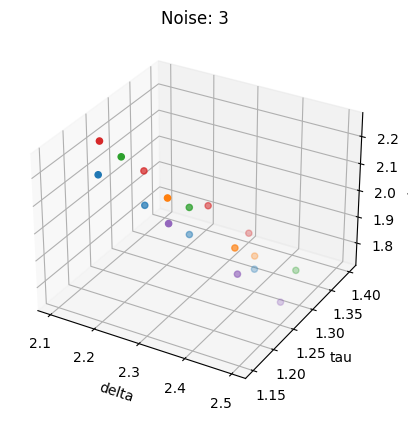

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

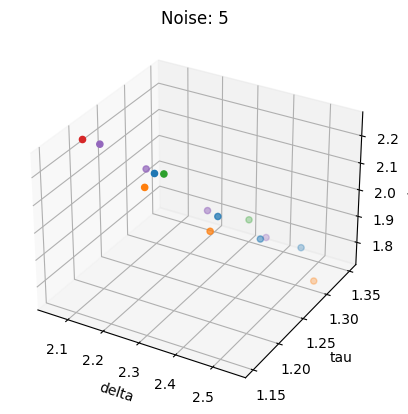

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

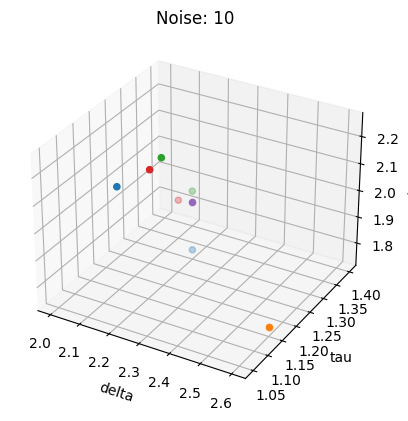

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()